# Transfer learning with VGG16

--- 

Here we use a pre-trained VGG16 model, replace and train the last layer (keep all other weights the same), and now predict our dog breeds!

In [48]:
import random
import numpy as np
from glob import glob
from src.models import detect_faces, detect_dogs, train_model
from src.utils import un_normalize_image

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
%load_ext autoreload
%autoreload 2

In [42]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [3]:
random.seed(12)

# load filenames for human and dog images
human_files = np.array(glob("../data/raw/lfw/*/*"))
dog_files = np.array(glob("../data/raw/dogImages/*/*/*"))
random.shuffle(human_files)
random.shuffle(dog_files)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [4]:
print(f"Some human files: \n{human_files[:4]}\n")
print(f"Some dog files: \n{dog_files[:4]}")

Some human files: 
['../data/raw/lfw\\Nicole_Hiltz\\Nicole_Hiltz_0001.jpg'
 '../data/raw/lfw\\Donald_Rumsfeld\\Donald_Rumsfeld_0020.jpg'
 '../data/raw/lfw\\Robbie_Coltrane\\Robbie_Coltrane_0001.jpg'
 '../data/raw/lfw\\Wolfgang_Clement\\Wolfgang_Clement_0001.jpg']

Some dog files: 
['../data/raw/dogImages\\test\\047.Chesapeake_bay_retriever\\Chesapeake_bay_retriever_03390.jpg'
 '../data/raw/dogImages\\train\\039.Bull_terrier\\Bull_terrier_02795.jpg'
 '../data/raw/dogImages\\train\\011.Australian_cattle_dog\\Australian_cattle_dog_00774.jpg'
 '../data/raw/dogImages\\train\\023.Bernese_mountain_dog\\Bernese_mountain_dog_01663.jpg']


In [5]:
breeds = [x.split('/')[3].split("\\")[3][:-10] for x in dog_files]
breeds = np.unique(breeds)
print(f"There are {len(breeds)} breeds in total\n")
print(f"example breeds: \n{breeds[:5]}")

There are 133 breeds in total

example breeds: 
['Affenpinscher' 'Afghan_hound' 'Airedale_terrier' 'Akita'
 'Alaskan_malamute']


<a id='step1'></a>
## Step 1: Detect Humans

Like in the previous notebooks, we use a pre-trained human face detector. 

In [6]:
# pick some human and dog files to test our face detector on
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Test the performance of the face_detector algorithm 
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += detect_faces.face_detector(human_path)
    dog_count += detect_faces.face_detector(dog_files_short[ii])
    
print(f'Faces were detected in {human_count}% of our human images, and {dog_count}% of our dog images')

Faces were detected in 98% of our human images, and 11% of our dog images


---
<a id='step2'></a>
## Step 2: Detect Dogs

And we use the pre-trained VGG16 model to detect dogs. Note that we have not changed the model here at all (unlike what we'll do later, where we replace the last dense layer and retrain that layer). Here we use the VGG16 model as is. It was trained to predict 1000 classes, and the classes 151, 152, ..., 268 are dogs. We just check whether our image is predicted to be in that [151, 268] range (by picking the class with the highest probability). If so, we say our images contains a dog. 

In [41]:
vgg16 = models.vgg16(pretrained=True)

# move model to GPU if cuda is available
if use_cuda:
    vgg16 = vgg16.cuda()
    
dog_detector_model = vgg16

In [10]:
# Testing the dog detector. This may take a while to run because of loading the vgg16 model. 
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += detect_dogs.dog_detector(human_path, dog_detector_model)
    dog_count += detect_dogs.dog_detector(dog_files_short[ii], dog_detector_model)
    
print(f'Dogs were detected in {human_count}% of our human images, and {dog_count}% of our dog images')

Dogs were detected in 2% of our human images, and 97% of our dog images


## Step 3: Look at some images and define transformations for training

Here we'll look at some raw images, and then show the transformations we'll perform on the images we train on (we'll randomly flip them, etc.. to reduce overfitting and to augment our dataset). 

### Data transformations and loaders for the VGG16 fine-tuning model

In [33]:
batch_size = 25
num_workers = 0

In [36]:
# These two transforms are used for the fine-tuning model
data_transform_bare  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])

data_transform  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])

# datasets
train_data = datasets.ImageFolder('../data/raw/dogImages/train', transform = data_transform)
valid_data = datasets.ImageFolder('../data/raw/dogImages/valid', transform = data_transform_bare)
test_data = datasets.ImageFolder('../data/raw/dogImages/test', transform = data_transform_bare)

# define the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

loaders = {'train' : train_loader, 'valid' : valid_loader, 'test': test_loader}

### Look at some raw images
Here we visualize some of our raw dog images. They are all different sizes. The VGG16 model expects colour input images of size 224x224, that's why we rescale them later.

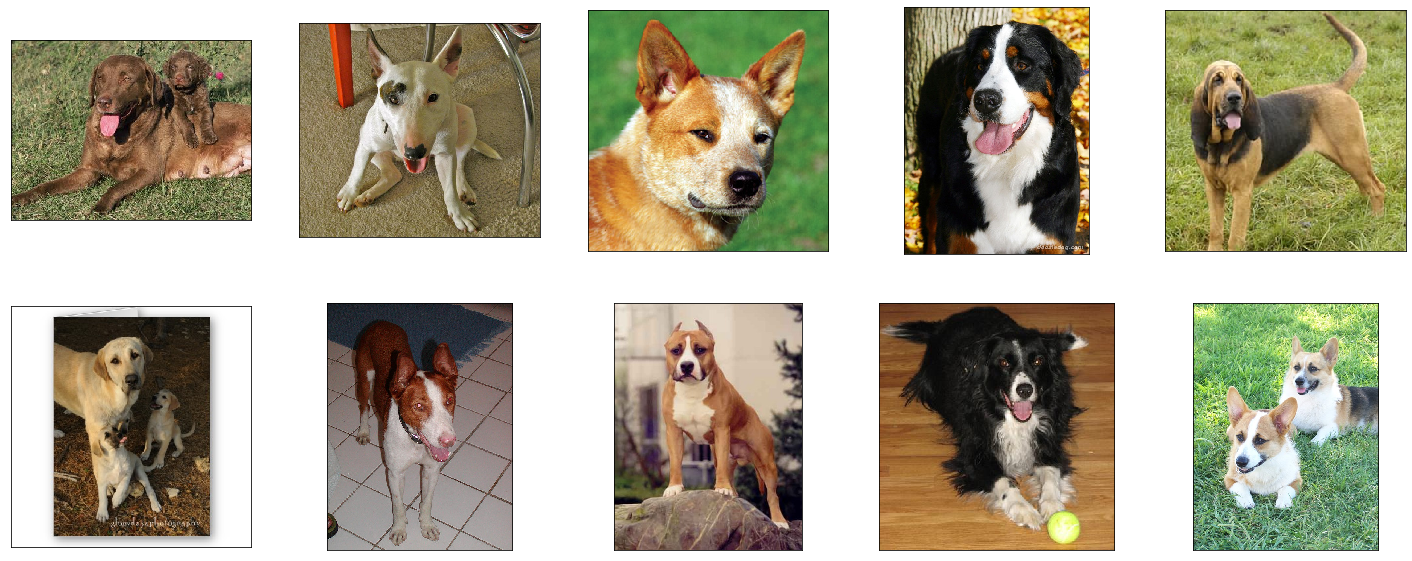

In [17]:
indices = np.random.randint(0, len(dog_files), 10)
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    image = Image.open(dog_files[idx])
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(image)

### Look at some transformed images
see if the transformations we applied (rotation, translation, etc..) are not too disturbing, it shouldn't be we cannot recognize the dogs ourselves anymore

In [21]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
un_norm = un_normalize_image.UnNormalize()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

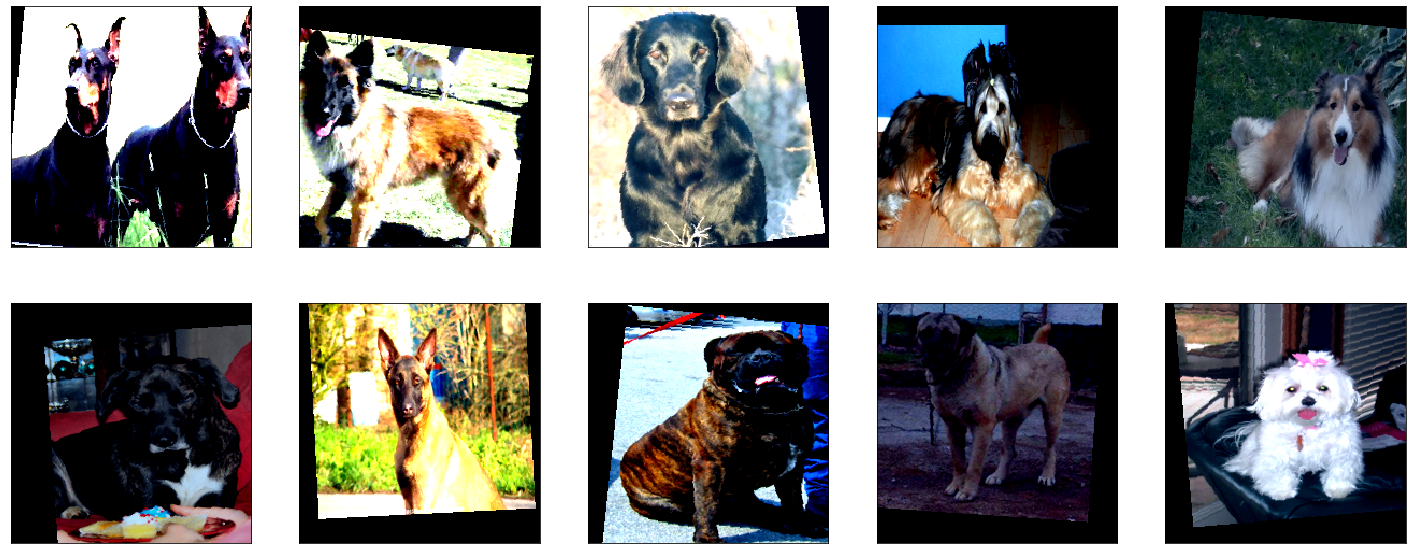

In [35]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next()

# plot some of the images in this batch
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    # resized images
    image = un_norm(images[idx])
    image = image.numpy()    

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)

---
<a id='step4'></a>
## Step 4: Create a CNN to classify dog breeds, using the VGG16 model


###  Model Architecture

I took the very last layer of the VGG16 model and replaced it with a new fully connected layer with 133 outputs (as we have 133 classes). This is reasonable because the dog-breed images are not that different from the images the vgg16 model was trained on (some of the classes it was predicting were dogs as well). The weights in the earlier layers were frozen (as they are used for detection of e.g. corners and lines, etc.. ) and the weights in all the fully connected layers were re-trained. 

I got XXXX percent accuracy by just removing the last layers, which seems pretty good.

In [43]:
# shape of the orignal vgg16 classifier
in_old = vgg16.classifier[6].in_features
print(vgg16.classifier[6].out_features) 
print(in_old) 

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
# replace last layer with a new linear layer with 133 outputs (the number of classes we have)
vgg16.classifier[6] = nn.Linear(in_old, 133)
model_transfer = vgg16

if use_cuda:
    model_transfer = model_transfer.cuda()

1000
4096


### Specify loss function and optimizer


In [49]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model


In [ ]:
# train the model
n_epochs = 100
model_transfer = train_model.train(n_epochs=n_epochs, 
                                   loaders=loaders, 
                                   model=model_transfer, 
                                   optimizer=optimizer_transfer, 
                                   criterion=criterion_transfer, 
                                   use_cuda=use_cuda, 
                                   save_path=f"../models/model_transfer_{n_epochs}.pt")
torch.cuda.empty_cache()

Starting epoch 1
	Training..


In [16]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_{n_epochs}.pt'))

###  Test the Model

I trained the models for XX epochs using a GPU, and saved it as `model_transfer_XX.pt`. When loading in that model, I get XXXX% accuracy.

In [23]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.458750


Test Accuracy: 87% (729/836)


### Predict with our model

Here we write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [18]:
# function that takes a path to an image as input and returns the dog breed that is predicted by the model.
data_transfer = {'train': train_data}

def predict_breed_transfer(img_path, model):
    model.eval()
    # load the image and return the predicted breed
    class_names = np.array([item[4:].replace("_", " ") for item in data_transfer['train'].classes])
    
    data_transform = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])    

    
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image)
    image.unsqueeze_(0)
    
    if use_cuda:
        image = image.to('cuda')
    prediction = model(image)
    probs = F.softmax(prediction, dim=1)
    top_probs, top_idx = probs.topk(5)
    top_probs = top_probs.cpu().detach().numpy()[0]
    
    return top_probs, class_names[top_idx.cpu().numpy()[0]]

In [19]:
dog_files[642]

'/data/dog_images/train/107.Norfolk_terrier/Norfolk_terrier_07035.jpg'

In [20]:
predict_breed_transfer(dog_files[642], model_transfer)

(array([  9.93476093e-01,   2.29418953e-03,   1.57615542e-03,
          1.15969754e-03,   6.16341946e-04], dtype=float32),
 array(['Norfolk terrier', 'Norwich terrier', 'Border terrier',
        'Australian terrier', 'Silky terrier'], 
       dtype='<U34'))

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [22]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, model_dog_detect, model_predict):
    ## handle cases for a human face, dog, and neither
    model_predict.eval()
    is_human = is_dog = False
    
    # check presence of human or dog
    if face_detector(img_path):
        is_human = True    
    
    if dog_detector(img_path, model_dog_detect):
        is_dog = True
        
    if not is_human and not is_dog:
        raise Exception('No human or dog detected in {}... supply an image with a human or a dog'.format(img_path))
    
    image = Image.open(img_path)
    probs, dog_names = predict_breed_transfer(img_path, model_predict)
    

        
    if is_human and is_dog:
        title = 'Both human and dog detected... This human/dog is predicted to be a .... {}!'.format(dog_names[0])
        fig, axs = plt.subplots(1,2, figsize = (10, 5))
        axs = axs.ravel()
    elif is_human:
        title = 'This human looks like a .....{}!'.format(dog_names[0])
        top_dog = dog_names[0].replace(' ', '_')
        dog_image_idx = np.where([top_dog in name for name in dog_files])[0][0]  
        image_dog = Image.open(dog_files[dog_image_idx])
        fig, axs = plt.subplots(1,3, figsize = (15, 5))
        axs = axs.ravel()
        axs[2].imshow(image_dog)
        axs[2].axis('off')        
    else:
        title = 'This dog is predicted to be a .... {}!'.format(dog_names[0])
        fig, axs = plt.subplots(1,2, figsize = (10, 5))
        axs = axs.ravel()
      
    xs = np.arange(1, len(probs)+1)
    axs[1].set_xticks(xs)
    axs[1].bar(xs, probs, align='center', alpha=0.5)
    axs[1].set_xticklabels(dog_names, rotation='vertical', fontsize=10)
        
    axs[0].imshow(image)
    axs[0].set_title(title)
    axs[0].axis('off')
    
    plt.tight_layout()

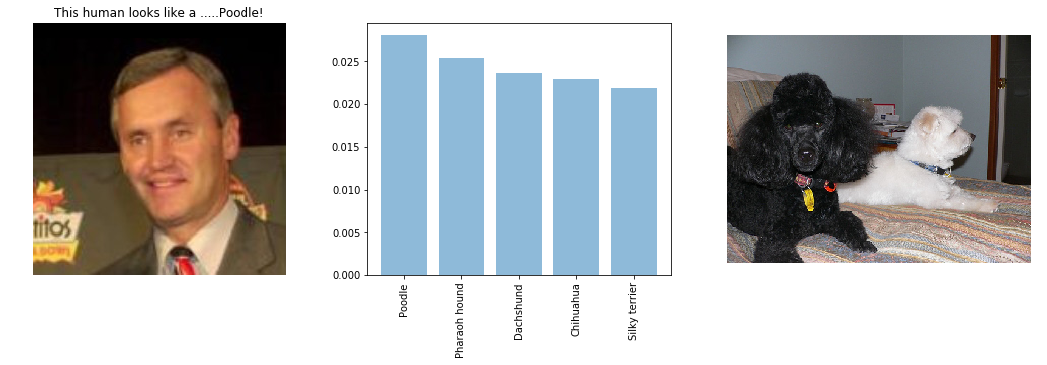

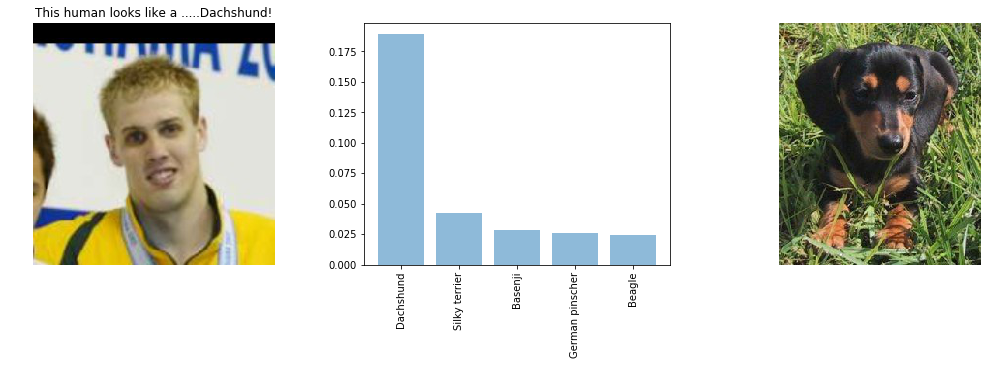

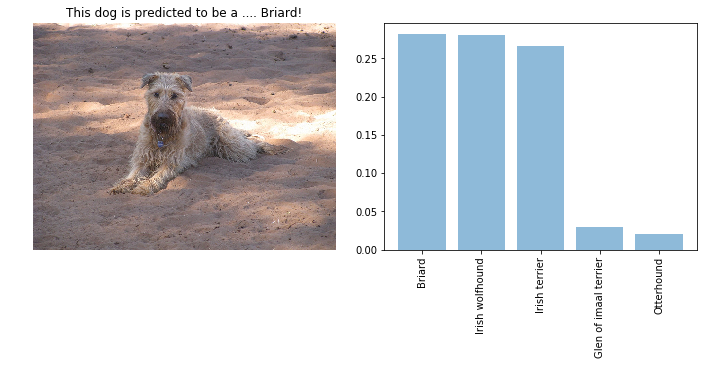

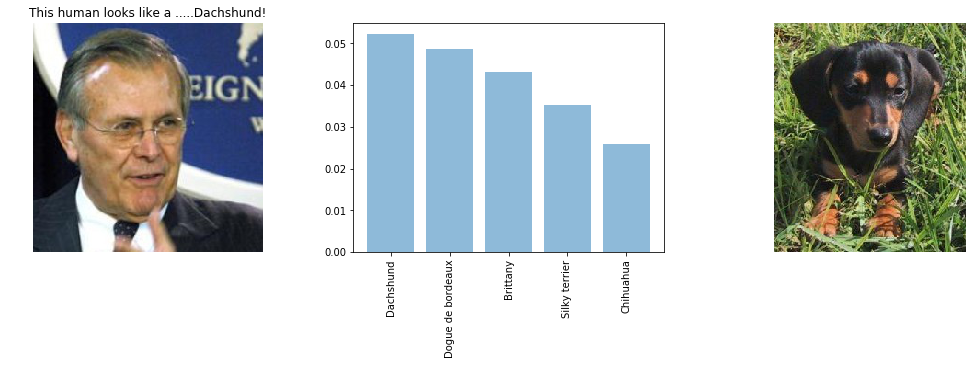

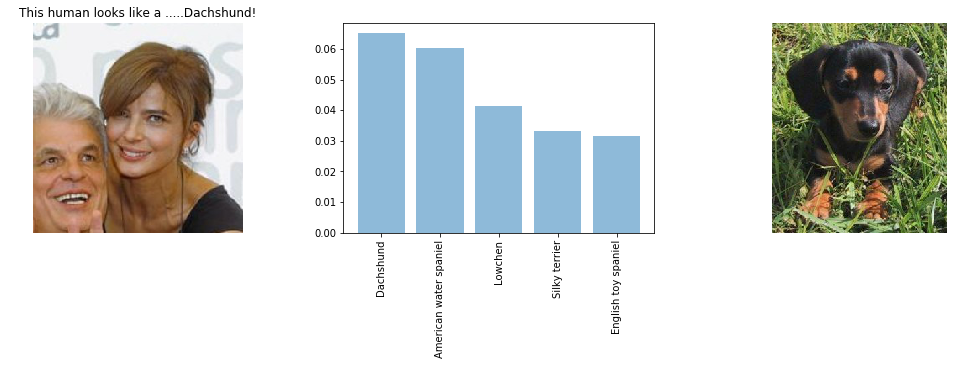

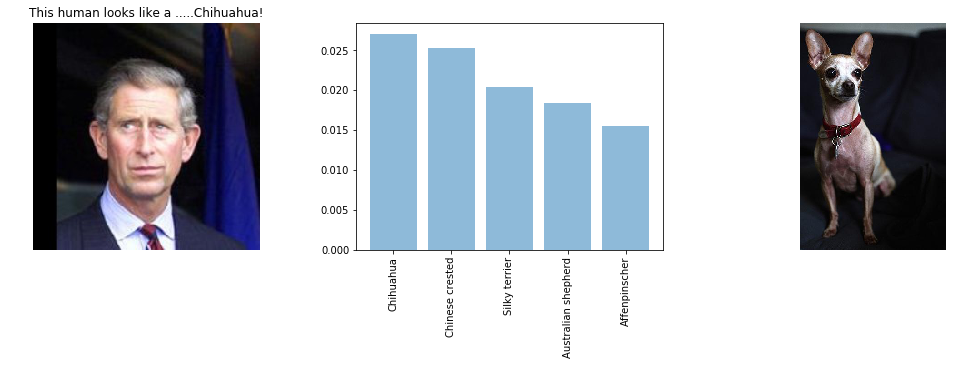

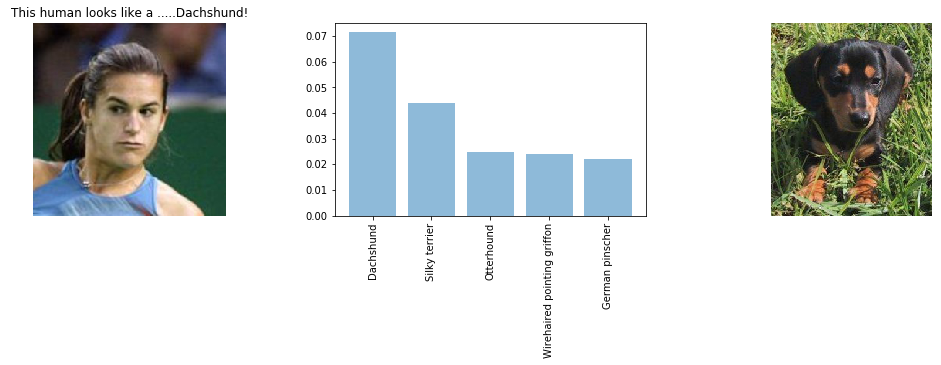

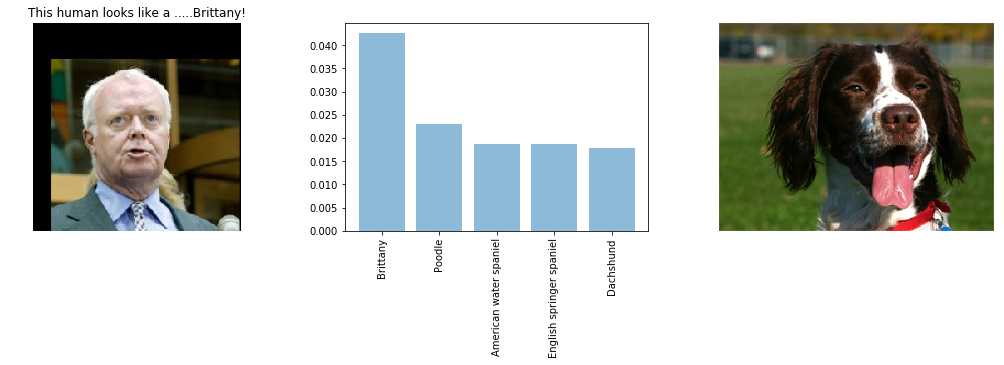

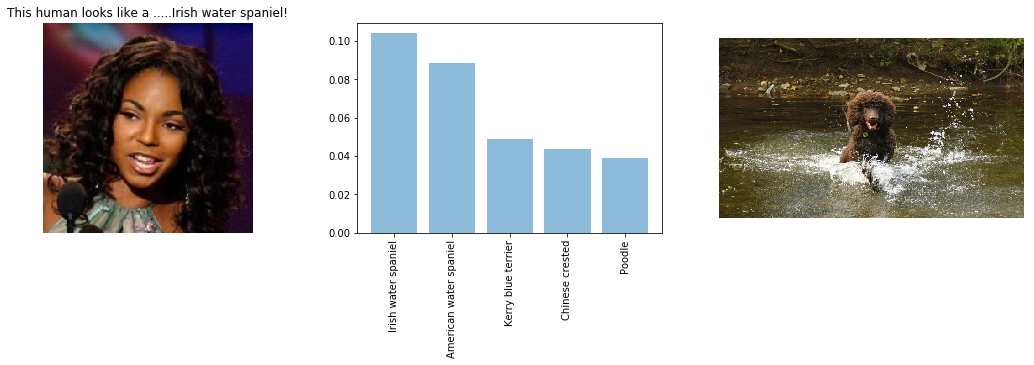

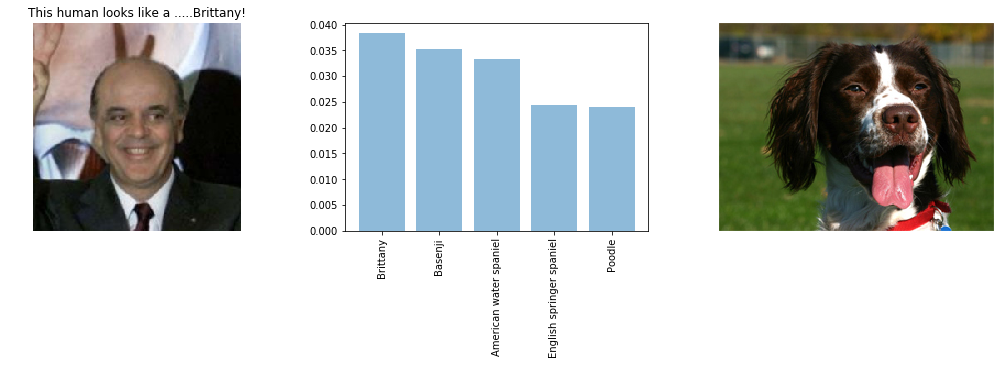

In [35]:
images = np.concatenate((human_files, dog_files))
np.random.shuffle(images)

for ii in range(10):
    run_app(images[ii], VGG16, model_transfer)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is slightly better than I had expected. My algorithm could be improved by 
* training on more images
* training for longer
* finding better hyperparameters for e.g. the ADAM optimizer

Sometimes if I rerun the app it can give quite different outputs, I guess with humans it's just not really sure most of the time (a lot of the probabilities of the top dogs are close together)

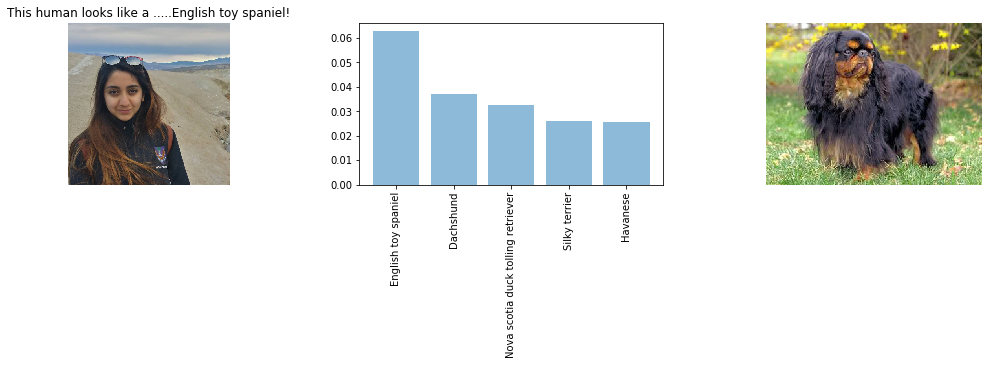

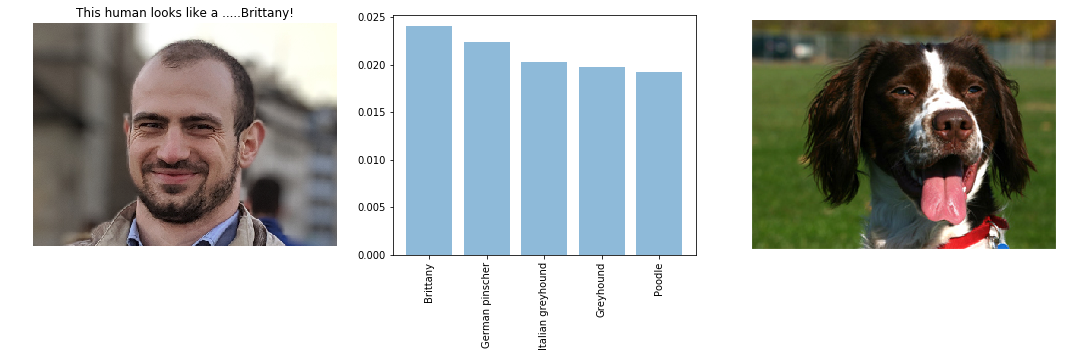

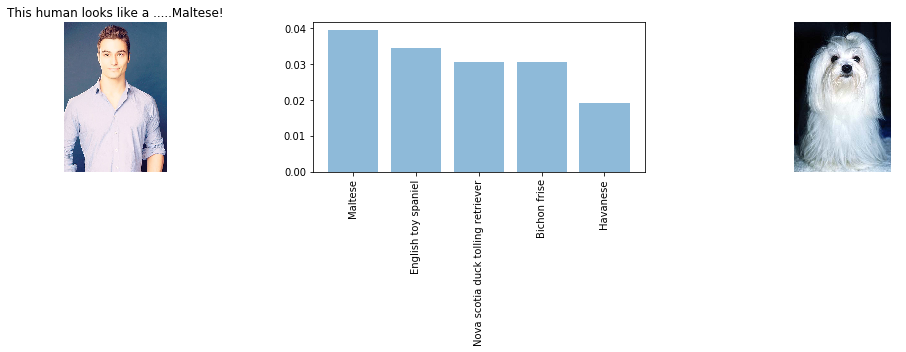

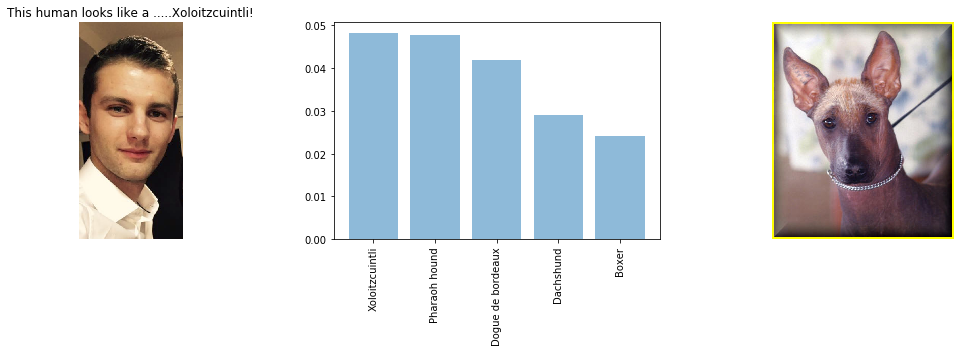

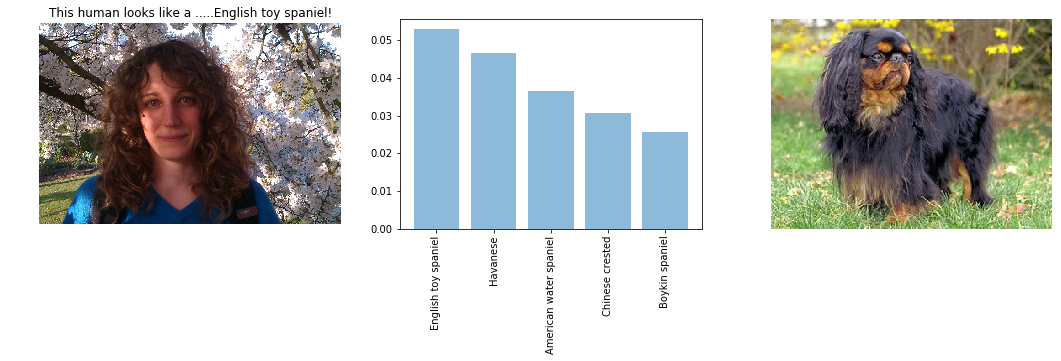

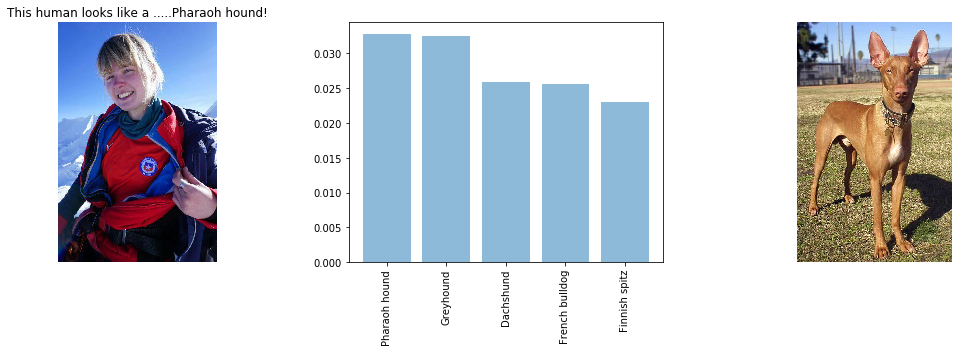

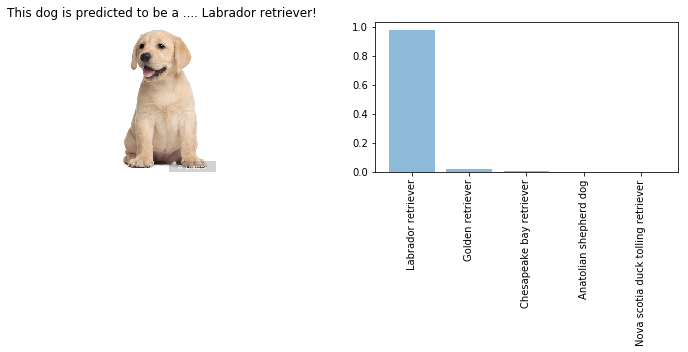

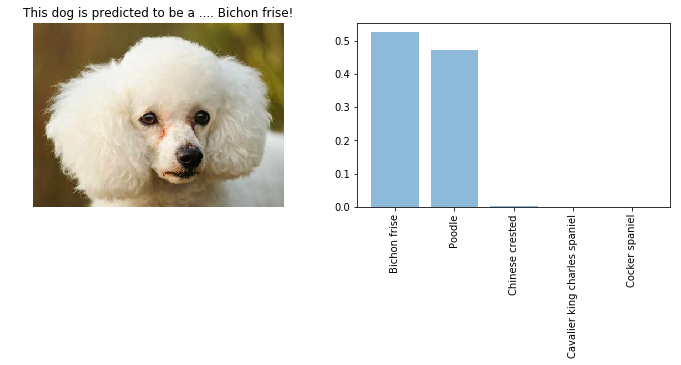

In [38]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

human_files_plot = ['aydan', 'emil.png', 'gianluca', 'antoine.png', 'hanne.jpg', 'froukje.jpg']
dog_files_plot = ['labrador.jpg', 'poodle.png']

## suggested code, below
for file in np.hstack((human_files_plot, dog_files_plot)):
    run_app(file, VGG16, model_transfer)